# H5: Digital Access Barriers and Food Deserts

**Hypothesis:** Tracts with higher digital access barriers (poor broadband, more seniors, more SNAP and no-vehicle households) are more likely to be food deserts.

**Approach:**
1. Load and clean Food Access Atlas data
2. Get real broadband data from Census ACS 2019
3. Construct Digital Barrier Index from 4 components
4. Exploratory Data Analysis
5. Create 4 key visualizations
6. Statistical validation (3 tests)
7. Results and conclusions

## **Imports, paths, config**

In [ ]:
# Imports, paths, config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from scipy.stats import pointbiserialr, mannwhitneyu, linregress
from imblearn.over_sampling import SMOTE # Added for SMOTE

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## Data Sources

1. **Food Access Research Atlas 2019** - USDA Economic Research Service
   - Source: https://www.ers.usda.gov/data-products/food-access-research-atlas/
   - Coverage: All U.S. census tracts
   - Variables: Food desert status, demographics, poverty

2. **Broadband Subscription Data** - Census ACS 5-Year 2019 (Table B28002)
   - Source: U.S. Census Bureau API
   - Measures: Household broadband subscription rates

## **DATA LOADING & CLEANING**
H5: Tracts with higher digital access barriers (poor broadband, more seniors, more SNAP and no-vehicle households) are more likely to be food deserts.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/CS418 Data Science Project/SUBMISSION FOLDER/DATASETS"
FAPATH = 'Food Access Research Atlas 2019.csv'
# Or use: FAPATH = 'Food Access Research Atlas 2019.csv' if in same folder

print("Loading Food Access Research Atlas 2019...")
atlas = pd.read_csv(FAPATH)
print(f"✓ Full atlas loaded: {atlas.shape[0]:,} tracts, {atlas.shape[1]} variables")

# Filter to Cook County (Chicago)
chicago = atlas[(atlas['State'] == 'Illinois') &
                (atlas['County'] == 'Cook County')].copy()
print(f"✓ Cook County tracts: {len(chicago):,}")

# Remove zero-population tracts
chicago = chicago[chicago['Pop2010'] > 0].copy()
print(f"✓ After removing zero-pop tracts: {len(chicago):,}")

# 1. Food Desert flag (1 = low-income & low-access at 1/10 mile)
chicago['FoodDesert'] = chicago['LILATracts_1And10'].fillna(0).astype(int)
print(f"\n✓ Food Desert tracts: {chicago['FoodDesert'].sum()} ({chicago['FoodDesert'].sum()/len(chicago)*100:.1f}%)")

# 2. Clean demographic variables (fill missing with 0)
for col in ['TractSeniors', 'TractSNAP', 'TractHUNV']:
    chicago[col] = chicago[col].fillna(0)

# 3. Households (replace 0 with NaN to avoid division errors)
chicago['OHU2010'] = chicago['OHU2010'].replace(0, np.nan)

# 4. Create share variables (percentages)
chicago['SeniorShare'] = (chicago['TractSeniors'] / chicago['Pop2010'] * 100).fillna(0)
chicago['SNAPShare'] = (chicago['TractSNAP'] / chicago['Pop2010'] * 100).fillna(0)
chicago['PctNoVehicle'] = (chicago['TractHUNV'] / chicago['OHU2010'] * 100).fillna(0)

# 5. Clean poverty rate
chicago['PovertyRate'] = chicago['PovertyRate'].fillna(chicago['PovertyRate'].median())

# 6. Create 11-digit GEOID for merging with Census data
chicago['GEOID'] = chicago['CensusTract'].astype(str).str.zfill(11)

print("\n✓ Variables created:")
print(f"  - SeniorShare: Mean = {chicago['SeniorShare'].mean():.1f}%")
print(f"  - SNAPShare: Mean = {chicago['SNAPShare'].mean():.1f}%")
print(f"  - PctNoVehicle: Mean = {chicago['PctNoVehicle'].mean():.1f}%")

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1bsY0sEYBQ4A1AVqA9z6JA-jJotfr5mzG/CS418 Data Science Project/SUBMISSION FOLDER/DATASETS
Loading Food Access Research Atlas 2019...
✓ Full atlas loaded: 72,531 tracts, 147 variables
✓ Cook County tracts: 1,314
✓ After removing zero-pop tracts: 1,314

✓ Food Desert tracts: 51 (3.9%)

✓ Variables created:
  - SeniorShare: Mean = 11.8%
  - SNAPShare: Mean = 6.5%
  - PctNoVehicle: Mean = 19.2%


## **BROADBAND DATA FROM CENSUS ACS**

In [ ]:
API_KEY = ''

print("Fetching broadband data from Census ACS 2019 ...")

base_url = 'https://api.census.gov/data/2019/acs/acs5'
variables = 'B28002_001E,B28002_004E,NAME'
geography = 'for=tract:*&in=state:17&in=county:031'
url = f"{base_url}?get={variables}&{geography}&key={API_KEY}"

response = requests.get(url)

# Added for debugging: print status code and response text
print(f"API Response Status Code: {response.status_code}")
print(f"API Response Text:\n{response.text[:500]}...") # Print first 500 chars to avoid very long output

if response.status_code == 200:
    try:
        data = response.json()
    except requests.exceptions.JSONDecodeError as e:
        print(f"❌ Error decoding JSON: {e}")
        print("The API returned a non-JSON response even with a 200 status code. Check response.text above.")
        data = None # Set data to None to prevent further errors

    if data:
        acs_broadband = pd.DataFrame(data[1:], columns=data[0])
        acs_broadband.columns = ['TotalHH', 'BroadbandHH', 'NAME', 'state', 'county', 'tract']

        acs_broadband['GEOID'] = (acs_broadband['state'] +
                                  acs_broadband['county'] +
                                  acs_broadband['tract'])

        acs_broadband['BroadbandHouseholdShare'] = (
            pd.to_numeric(acs_broadband['BroadbandHH'], errors='coerce') /
            pd.to_numeric(acs_broadband['TotalHH'], errors='coerce')
        ).fillna(0).clip(0, 1)

        print(f"✓ Loaded broadband data for {len(acs_broadband):,} Cook County tracts")
        print(f"  Mean broadband share: {acs_broadband['BroadbandHouseholdShare'].mean():.1%}")
        print(f"  Range: {acs_broadband['BroadbandHouseholdShare'].min():.1%} - {acs_broadband['BroadbandHouseholdShare'].max():.1%}")

        chicago = chicago.merge(
            acs_broadband[['GEOID', 'BroadbandHouseholdShare']],
            on='GEOID',
            how='left'
        )

        merged_count = chicago['BroadbandHouseholdShare'].notna().sum()
        print(f"\n✓ Merged with Chicago data: {merged_count}/{len(chicago)} tracts ({merged_count/len(chicago)*100:.1f}%)")

        print("\nSample data:")
        print(chicago[['GEOID', 'FoodDesert', 'BroadbandHouseholdShare', 'PovertyRate']].head())

else:
    print(f"❌ Error {response.status_code}: Could not fetch data")
    print("Check your API key at https://api.census.gov/data/key_signup.html or the URL parameters.")

Fetching broadband data from Census ACS 2019 ...
API Response Status Code: 200
API Response Text:
[["B28002_001E","B28002_004E","NAME","state","county","tract"],
["575","392","Census Tract 6302, Cook County, Illinois","17","031","630200"],
["1544","1242","Census Tract 5807, Cook County, Illinois","17","031","580700"],
["1172","917","Census Tract 5906, Cook County, Illinois","17","031","590600"],
["1084","917","Census Tract 6007, Cook County, Illinois","17","031","600700"],
["574","322","Census Tract 6119, Cook County, Illinois","17","031","611900"],
["1517","1326","Census Tract 8045.05, Cook...
✓ Loaded broadband data for 1,319 Cook County tracts
  Mean broadband share: 79.4%
  Range: 0.0% - 100.0%

✓ Merged with Chicago data: 1314/1314 tracts (100.0%)

Sample data:
         GEOID  FoodDesert  BroadbandHouseholdShare  PovertyRate
0  17031010100           0                 0.757088         35.8
1  17031010201           0                 0.761194         36.8
2  17031010202           0  

## **DIGITAL BARRIER INDEX CONSTRUCTION**

We construct a composite Digital Barrier Index from 4 standardized components:

1. **Broadband Access** (inverted): Lower subscription = higher barrier
2. **Senior Share**: Higher % seniors = higher barrier (digital literacy)
3. **SNAP Share**: Higher % SNAP recipients = higher barrier (economic)
4. **No Vehicle**: Higher % without vehicles = higher barrier (mobility/access)

Each component is z-score standardized, then summed to create the index.

In [ ]:
features_for_index = ['BroadbandHouseholdShare', 'SeniorShare', 'SNAPShare', 'PctNoVehicle']

# Create barrier dataframe (fill any remaining NaN with median)
barrier_df = chicago[features_for_index].copy()
barrier_df = barrier_df.fillna(barrier_df.median())

# Standardize to z-scores (mean=0, std=1)
scaler = StandardScaler()
scaled = scaler.fit_transform(barrier_df)

# Create Digital Barrier Index
# Note: Invert broadband (high broadband = low barrier, so flip the sign)
digital_barrier_index = -scaled[:, 0] + scaled[:, 1] + scaled[:, 2] + scaled[:, 3]
chicago['DigitalBarrierIndex'] = digital_barrier_index

print("✓ Digital Barrier Index created")
print(f"\nIndex Statistics:")
print(f"  Mean: {chicago['DigitalBarrierIndex'].mean():.3f}")
print(f"  Std:  {chicago['DigitalBarrierIndex'].std():.3f}")
print(f"  Min:  {chicago['DigitalBarrierIndex'].min():.2f}")
print(f"  Max:  {chicago['DigitalBarrierIndex'].max():.2f}")

# Show by food desert status
print(f"\nBy Food Desert Status:")
print(chicago.groupby('FoodDesert')['DigitalBarrierIndex'].agg(['mean', 'median', 'std']))

✓ Digital Barrier Index created

Index Statistics:
  Mean: 0.000
  Std:  2.683
  Min:  -4.60
  Max:  35.11

By Food Desert Status:
                mean    median       std
FoodDesert                              
0          -0.031021 -0.541459  2.696812
1           0.768237  0.163323  2.213584


## **BASIC EDA**

In [ ]:
# 1. Summary statistics
print("\n1. Summary Statistics:")
summary_vars = ['DigitalBarrierIndex', 'BroadbandHouseholdShare', 'SeniorShare',
                'SNAPShare', 'PctNoVehicle', 'PovertyRate', 'FoodDesert']
print(chicago[summary_vars].describe())

# 2. Food desert distribution
print("\n2. Food Desert Distribution:")
fd_counts = chicago['FoodDesert'].value_counts()
print(fd_counts)
print(f"   Food Desert Rate: {(chicago['FoodDesert'].sum() / len(chicago) * 100):.2f}%")

# 3. Digital Barrier Index by food desert status
print("\n3. Digital Barrier Index by Food Desert Status:")
group_stats = chicago.groupby('FoodDesert')['DigitalBarrierIndex'].agg(['mean', 'median', 'std', 'count'])
print(group_stats)

diff = group_stats.loc[1, 'mean'] - group_stats.loc[0, 'mean']
pct_diff = (diff / abs(group_stats.loc[0, 'mean'])) * 100 if group_stats.loc[0, 'mean'] != 0 else 0
print(f"\n   Mean difference: {diff:.3f} ({pct_diff:.1f}% higher in food deserts)")

# 4. Correlation matrix
print("\n4. Correlation Matrix:")
corr_vars = ['FoodDesert', 'DigitalBarrierIndex', 'BroadbandHouseholdShare',
             'SeniorShare', 'SNAPShare', 'PctNoVehicle', 'PovertyRate']
corr_matrix = chicago[corr_vars].corr()
print(corr_matrix[['FoodDesert']].round(3))


1. Summary Statistics:
       DigitalBarrierIndex  BroadbandHouseholdShare  SeniorShare    SNAPShare  \
count         1.314000e+03              1314.000000  1314.000000  1314.000000   
mean          9.084565e-16                 0.796603    11.774556     6.533242   
std           2.683421e+00                 0.114953     6.040916     6.565097   
min          -4.602229e+00                 0.302064     1.567944     0.000000   
25%          -1.758969e+00                 0.724230     7.458044     2.120515   
50%          -5.153831e-01                 0.814522    10.901960     5.014670   
75%           1.217430e+00                 0.884803    15.004089     9.153106   
max           3.511168e+01                 1.000000    44.746884   123.650386   

       PctNoVehicle  PovertyRate   FoodDesert  
count   1314.000000  1314.000000  1314.000000  
mean      19.241957    17.140715     0.038813  
std       17.937855    12.932596     0.193222  
min        0.000000     0.300000     0.000000  
25%   

## **VISUALIZATIONS**

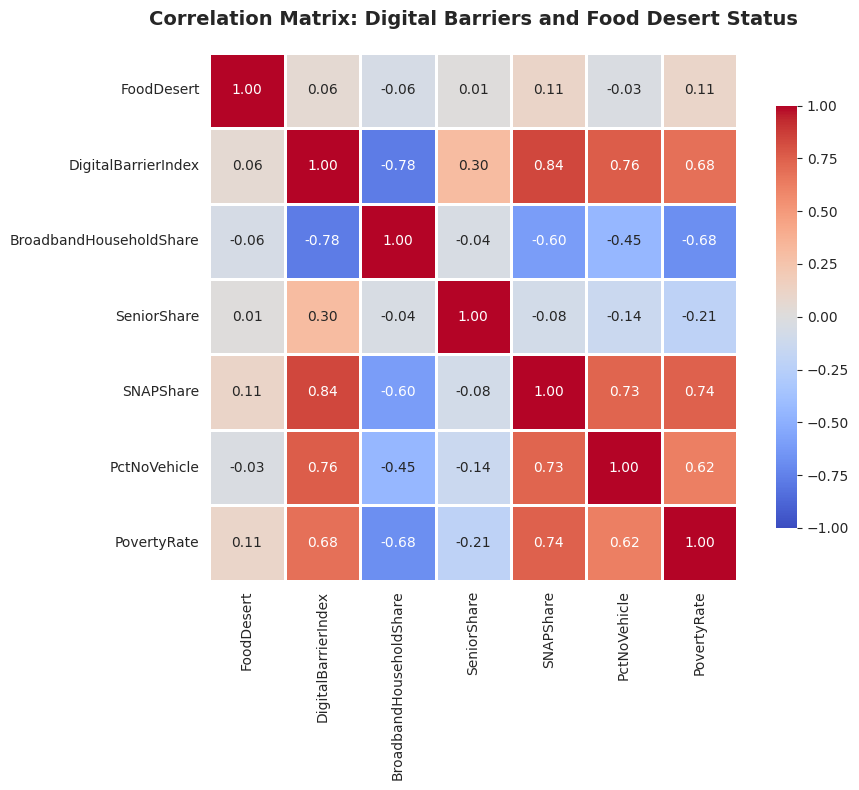


Key Correlations with Food Desert:
  Digital Barrier Index:  r = +0.058
  Broadband Access:       r = -0.057
  No Vehicle %:           r = -0.028
  SNAP Share:             r = +0.110


In [ ]:
corr_vars = ['FoodDesert', 'DigitalBarrierIndex', 'BroadbandHouseholdShare',
             'SeniorShare', 'SNAPShare', 'PctNoVehicle', 'PovertyRate']
corr_matrix = chicago[corr_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Correlation Matrix: Digital Barriers and Food Desert Status',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nKey Correlations with Food Desert:")
print(f"  Digital Barrier Index:  r = {corr_matrix.loc['FoodDesert', 'DigitalBarrierIndex']:+.3f}")
print(f"  Broadband Access:       r = {corr_matrix.loc['FoodDesert', 'BroadbandHouseholdShare']:+.3f}")
print(f"  No Vehicle %:           r = {corr_matrix.loc['FoodDesert', 'PctNoVehicle']:+.3f}")
print(f"  SNAP Share:             r = {corr_matrix.loc['FoodDesert', 'SNAPShare']:+.3f}")

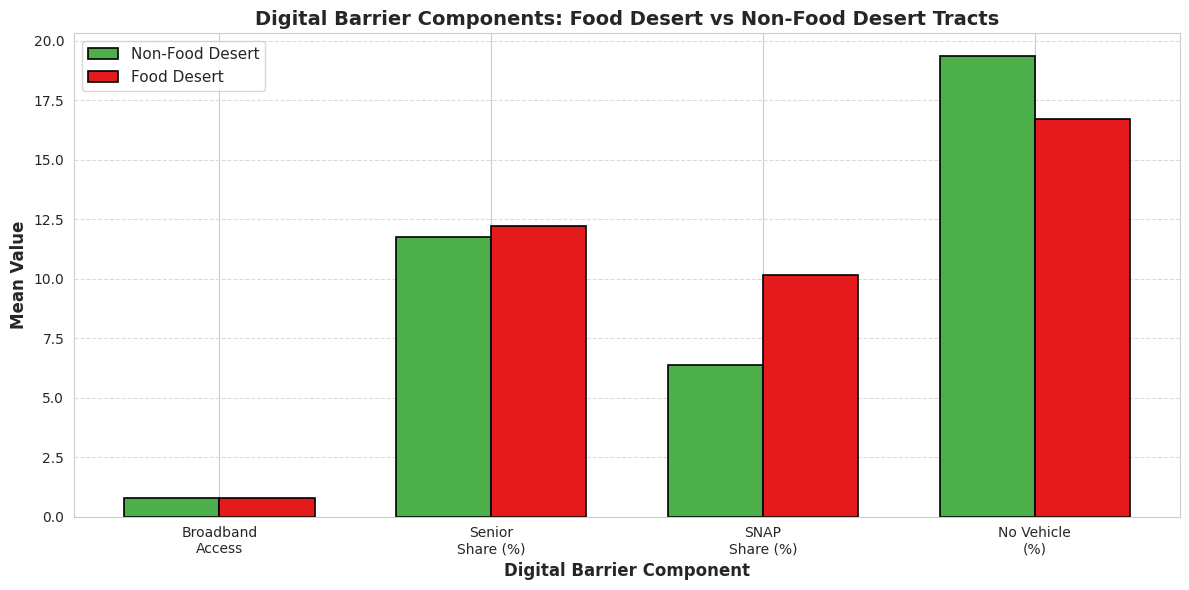


Component Differences (Food Desert - Non-Food Desert):
  BroadbandHouseholdShare  : -0.034 (-4.3%)
  SeniorShare              : +0.464 (+3.9%)
  SNAPShare                : +3.754 (+58.8%)
  PctNoVehicle             : -2.614 (-13.5%)


In [ ]:
component_means = chicago.groupby('FoodDesert')[['BroadbandHouseholdShare',
                                                   'SeniorShare',
                                                   'SNAPShare',
                                                   'PctNoVehicle']].mean()

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(4)
width = 0.35

bars1 = ax.bar(x - width/2, component_means.iloc[0], width,
               label='Non-Food Desert', color='#4daf4a', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, component_means.iloc[1], width,
               label='Food Desert', color='#e41a1c', edgecolor='black', linewidth=1.2)

ax.set_xlabel('Digital Barrier Component', fontweight='bold', fontsize=12)
ax.set_ylabel('Mean Value', fontweight='bold', fontsize=12)
ax.set_title('Digital Barrier Components: Food Desert vs Non-Food Desert Tracts',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Broadband\nAccess', 'Senior\nShare (%)',
                    'SNAP\nShare (%)', 'No Vehicle\n(%)'])
ax.legend(fontsize=11, loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("\nComponent Differences (Food Desert - Non-Food Desert):")
for col in component_means.columns:
    diff = component_means.iloc[1][col] - component_means.iloc[0][col]
    pct_change = (diff / component_means.iloc[0][col] * 100) if component_means.iloc[0][col] != 0 else 0
    print(f"  {col:25s}: {diff:+.3f} ({pct_change:+.1f}%)")

/tmp/ipython-input-3687954332.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=status_labels, y=chicago['DigitalBarrierIndex'],


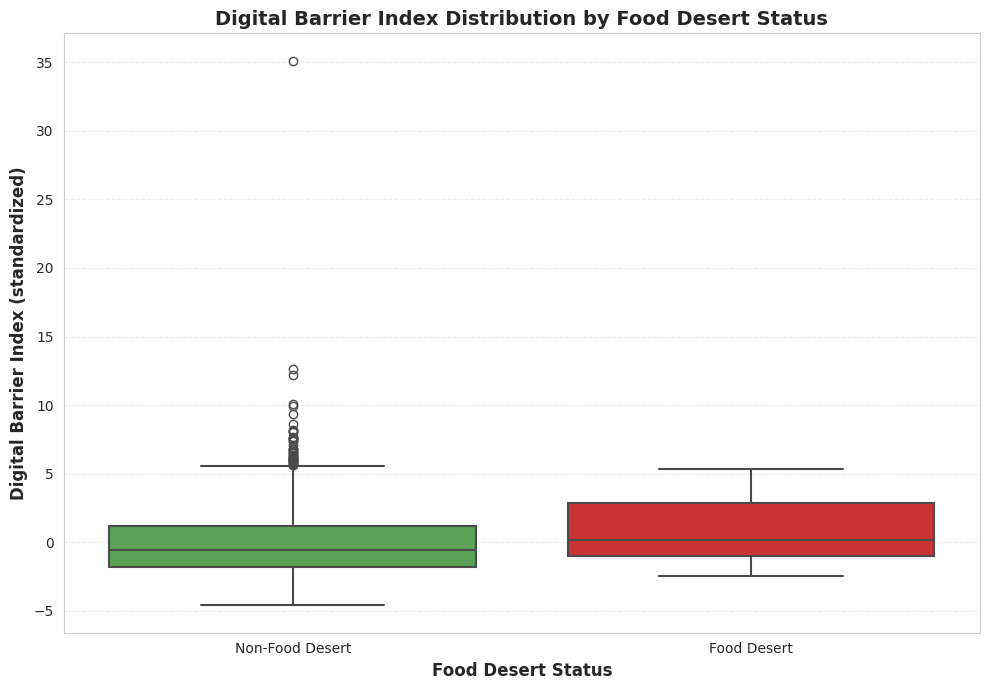


Distribution Statistics:
  Non-Food Desert:
    Mean:   -0.031
    Median: -0.541
    IQR:    2.964

  Food Desert:
    Mean:   0.768
    Median: 0.163
    IQR:    3.878

  Difference:
    Mean difference:   0.799
    Median difference: 0.705


In [ ]:
plt.figure(figsize=(10, 7))
status_labels = chicago['FoodDesert'].map({0: 'Non-Food Desert', 1: 'Food Desert'})

sns.boxplot(x=status_labels, y=chicago['DigitalBarrierIndex'],
            palette=['#4daf4a', '#e41a1c'], linewidth=1.5)

plt.xlabel('Food Desert Status', fontweight='bold', fontsize=12)
plt.ylabel('Digital Barrier Index (standardized)', fontweight='bold', fontsize=12)
plt.title('Digital Barrier Index Distribution by Food Desert Status',
          fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate statistics
fd_group = chicago[chicago['FoodDesert'] == 1]['DigitalBarrierIndex']
nfd_group = chicago[chicago['FoodDesert'] == 0]['DigitalBarrierIndex']

print("\nDistribution Statistics:")
print(f"  Non-Food Desert:")
print(f"    Mean:   {nfd_group.mean():.3f}")
print(f"    Median: {nfd_group.median():.3f}")
print(f"    IQR:    {nfd_group.quantile(0.75) - nfd_group.quantile(0.25):.3f}")
print(f"\n  Food Desert:")
print(f"    Mean:   {fd_group.mean():.3f}")
print(f"    Median: {fd_group.median():.3f}")
print(f"    IQR:    {fd_group.quantile(0.75) - fd_group.quantile(0.25):.3f}")
print(f"\n  Difference:")
print(f"    Mean difference:   {fd_group.mean() - nfd_group.mean():.3f}")
print(f"    Median difference: {fd_group.median() - nfd_group.median():.3f}")

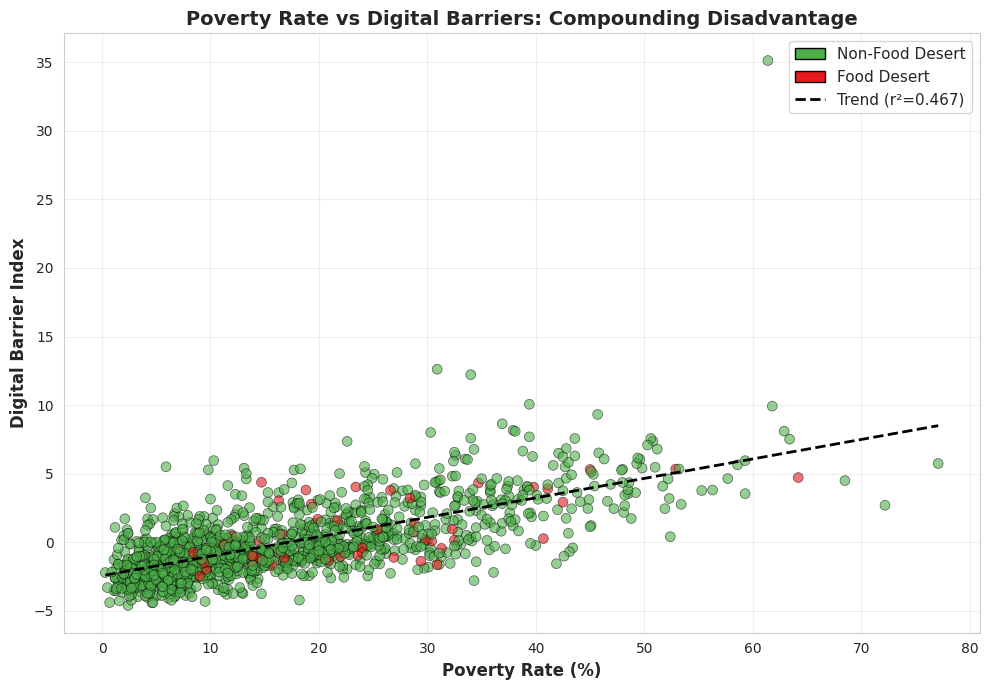


Poverty-Digital Barrier Correlation:
  Correlation (r):  0.684
  R-squared:        0.467
  P-value:          1.39e-181

Interpretation: Poverty explains 46.7% of variance in digital barriers.
Food deserts cluster in high-poverty, high-barrier areas.


In [ ]:
plt.figure(figsize=(10, 7))
colors = chicago['FoodDesert'].map({0: '#4daf4a', 1: '#e41a1c'})

plt.scatter(chicago['PovertyRate'], chicago['DigitalBarrierIndex'],
            c=colors, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Add trendline
slope, intercept, r_value, p_value, std_err = linregress(
    chicago['PovertyRate'],
    chicago['DigitalBarrierIndex']
)
line_x = np.array([chicago['PovertyRate'].min(), chicago['PovertyRate'].max()])
line_y = slope * line_x + intercept
plt.plot(line_x, line_y, 'k--', linewidth=2)

plt.xlabel('Poverty Rate (%)', fontweight='bold', fontsize=12)
plt.ylabel('Digital Barrier Index', fontweight='bold', fontsize=12)
plt.title('Poverty Rate vs Digital Barriers: Compounding Disadvantage',
          fontsize=14, fontweight='bold')

# Custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#4daf4a', edgecolor='black', label='Non-Food Desert'),
    Patch(facecolor='#e41a1c', edgecolor='black', label='Food Desert'),
    plt.Line2D([0], [0], color='k', linestyle='--', linewidth=2,
               label=f'Trend (r²={r_value**2:.3f})')
]
plt.legend(handles=legend_elements, fontsize=11)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nPoverty-Digital Barrier Correlation:")
print(f"  Correlation (r):  {r_value:.3f}")
print(f"  R-squared:        {r_value**2:.3f}")
print(f"  P-value:          {p_value:.2e}")
print(f"\nInterpretation: Poverty explains {r_value**2*100:.1f}% of variance in digital barriers.")
print(f"Food deserts cluster in high-poverty, high-barrier areas.")

## **STATISTICAL TESTS**

Three independent tests to validate H5:
1. **Point-Biserial Correlation** : Association strength
2. **Mann-Whitney U Test** : Group comparison (non-parametric)
3. **Logistic Regression** : Predictive modeling


In [ ]:
corr, pval = pointbiserialr(chicago['FoodDesert'], chicago['DigitalBarrierIndex'])

print(f"\nPoint-Biserial Correlation:")
print(f"  Correlation coefficient (r): {corr:.3f}")
print(f"  P-value: {pval:.2e}")
print(f"  Significance: {'✓ Significant' if pval < 0.05 else '✗ Not significant'} at α=0.05")
print(f"\nInterpretation:")
print(f"  - Food desert status explains {(corr**2)*100:.2f}% of variance in digital barriers")
print(f"  - Positive correlation indicates higher barriers → more likely food desert")


Point-Biserial Correlation:
  Correlation coefficient (r): 0.058
  P-value: 3.70e-02
  Significance: ✓ Significant at α=0.05

Interpretation:
  - Food desert status explains 0.33% of variance in digital barriers
  - Positive correlation indicates higher barriers → more likely food desert


In [ ]:
fd_group = chicago[chicago['FoodDesert'] == 1]['DigitalBarrierIndex']
nfd_group = chicago[chicago['FoodDesert'] == 0]['DigitalBarrierIndex']

stat, p_value = mannwhitneyu(fd_group, nfd_group, alternative='greater')

print(f"\nMann-Whitney U Test (one-tailed: Food Desert > Non-Food Desert):")
print(f"  U-statistic: {stat:.2f}")
print(f"  P-value: {p_value:.4e}")
print(f"  Significance: {'✓ Significant' if p_value < 0.05 else '✗ Not significant'} at α=0.05")
print(f"\nInterpretation:")
print(f"  - Food desert tracts have {'significantly' if p_value < 0.05 else 'not significantly'} higher digital barriers")
print(f"  - This test is robust to outliers and non-normal distributions")


Mann-Whitney U Test (one-tailed: Food Desert > Non-Food Desert):
  U-statistic: 39669.00
  P-value: 2.4876e-03
  Significance: ✓ Significant at α=0.05

Interpretation:
  - Food desert tracts have significantly higher digital barriers
  - This test is robust to outliers and non-normal distributions


In [ ]:
X = chicago[['DigitalBarrierIndex', 'PovertyRate']].fillna(0)
y = chicago['FoodDesert']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Food Desert', 'Food Desert']))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.3f}")

print("\nModel Coefficients:")
for var, coef in zip(['DigitalBarrierIndex', 'PovertyRate'], logreg.coef_[0]):
    print(f"  {var:20s}: {coef:+.4f}")
print(f"  {'Intercept':20s}: {logreg.intercept_[0]:+.4f}")


Classification Report:
                 precision    recall  f1-score   support

Non-Food Desert       0.96      1.00      0.98       380
    Food Desert       0.00      0.00      0.00        15

       accuracy                           0.96       395
      macro avg       0.48      0.50      0.49       395
   weighted avg       0.93      0.96      0.94       395


ROC-AUC Score: 0.667

Model Coefficients:
  DigitalBarrierIndex : -0.0014
  PovertyRate         : +0.0353
  Intercept           : -3.9206


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


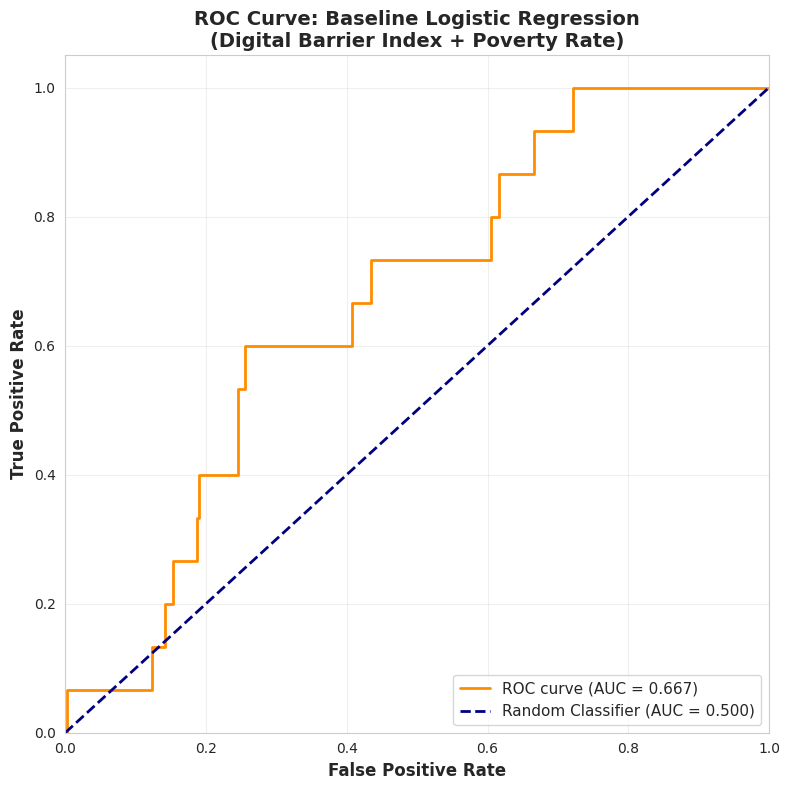

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold', fontsize=12)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=12)
plt.title('ROC Curve: Baseline Logistic Regression\n(Digital Barrier Index + Poverty Rate)',
          fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
logreg_balanced = LogisticRegression(
    random_state=42,
    class_weight='balanced',  # ← KEY FIX
    max_iter=1000
)
logreg_balanced.fit(X_train, y_train)

y_pred_balanced = logreg_balanced.predict(X_test)
y_pred_proba_balanced = logreg_balanced.predict_proba(X_test)[:, 1]

print("\nClassification Report (Balanced):")
print(classification_report(y_test, y_pred_balanced,
                          target_names=['Non-Food Desert', 'Food Desert']))

roc_auc_balanced = roc_auc_score(y_test, y_pred_proba_balanced)
print(f"\nROC-AUC Score (Balanced): {roc_auc_balanced:.3f}")
print(f"Improvement over baseline: {roc_auc_balanced - roc_auc:+.3f}")

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_balanced)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                 No    Yes")
print(f"Actual No    {cm[0,0]:5d} {cm[0,1]:5d}")
print(f"Actual Yes   {cm[1,0]:5d} {cm[1,1]:5d}")


Classification Report (Balanced):
                 precision    recall  f1-score   support

Non-Food Desert       0.98      0.68      0.80       380
    Food Desert       0.07      0.60      0.12        15

       accuracy                           0.68       395
      macro avg       0.52      0.64      0.46       395
   weighted avg       0.94      0.68      0.78       395


ROC-AUC Score (Balanced): 0.658
Improvement over baseline: -0.009

Confusion Matrix:
                 Predicted
                 No    Yes
Actual No      260   120
Actual Yes       6     9


In [ ]:
# Re-train model with ALL individual components instead of just the index
X_expanded = chicago[['BroadbandHouseholdShare', 'SeniorShare', 'SNAPShare',
                      'PctNoVehicle', 'PovertyRate']].fillna(0)
y_expanded = chicago['FoodDesert']

# Train-test split
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(
    X_expanded, y_expanded, test_size=0.3, random_state=42, stratify=y_expanded
)

# Fit logistic regression with expanded features
log_reg_expanded = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
log_reg_expanded.fit(X_train_exp, y_train_exp)

# Extract coefficients
feature_names_expanded = ['Broadband Access', 'Senior Share', 'SNAP Share',
                          'No Vehicle', 'Poverty Rate']
coefficients_expanded = log_reg_expanded.coef_[0]

# Create DataFrame for plotting
coef_df = pd.DataFrame({
    'Feature': feature_names_expanded,
    'Coefficient': coefficients_expanded,
    'AbsCoefficient': np.abs(coefficients_expanded)
}).sort_values('Coefficient', ascending=True)

# Model performance with expanded features
y_pred_exp = log_reg_expanded.predict(X_test_exp)
y_pred_proba_exp = log_reg_expanded.predict_proba(X_test_exp)[:, 1]
roc_auc_exp = roc_auc_score(y_test_exp, y_pred_proba_exp)

print(f"\nROC-AUC Score (Expanded): {roc_auc_exp:.3f}")

print(f"\nRegression Coefficients (Individual Components):")
print("-"*70)
for idx, row in coef_df.iterrows():
    direction = "Increases" if row['Coefficient'] > 0 else "Decreases"
    print(f"  {row['Feature']:25s}: {row['Coefficient']:+.4f} → {direction} food desert likelihood")

print(f"\nRanked by Predictive Strength (Absolute Value):")
print("-"*70)
coef_abs = coef_df.sort_values('AbsCoefficient', ascending=False)
for idx, (i, row) in enumerate(coef_abs.iterrows(), 1):
    print(f"  {idx}. {row['Feature']:25s}: {row['Coefficient']:+.4f}  (|{row['AbsCoefficient']:.4f}|)")

print(f"\nModel Performance Comparison:")
print(f"  Baseline (2 features):  ROC-AUC = {roc_auc:.3f}")
print(f"  Balanced (2 features):  ROC-AUC = {roc_auc_balanced:.3f}")
print(f"  Expanded (5 features):  ROC-AUC = {roc_auc_exp:.3f}")
print(f"  Improvement: {roc_auc_exp - roc_auc:+.3f}")


ROC-AUC Score (Expanded): 0.820

Regression Coefficients (Individual Components):
----------------------------------------------------------------------
  No Vehicle               : -0.1489 → Decreases food desert likelihood
  Senior Share             : +0.0804 → Increases food desert likelihood
  Poverty Rate             : +0.0823 → Increases food desert likelihood
  SNAP Share               : +0.3654 → Increases food desert likelihood
  Broadband Access         : +1.6419 → Increases food desert likelihood

Ranked by Predictive Strength (Absolute Value):
----------------------------------------------------------------------
  1. Broadband Access         : +1.6419  (|1.6419|)
  2. SNAP Share               : +0.3654  (|0.3654|)
  3. No Vehicle               : -0.1489  (|0.1489|)
  4. Poverty Rate             : +0.0823  (|0.0823|)
  5. Senior Share             : +0.0804  (|0.0804|)

Model Performance Comparison:
  Baseline (2 features):  ROC-AUC = 0.667
  Balanced (2 features):  ROC-AUC

In [ ]:
# Apply SMOTE to training data only
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_sm, y_train_sm = smote.fit_resample(X_train_exp, y_train_exp)

print(f"\nOriginal training set:")
print(f"  Non-Food Desert: {(y_train_exp == 0).sum()}")
print(f"  Food Desert: {(y_train_exp == 1).sum()}")
print(f"\nAfter SMOTE:")
print(f"  Non-Food Desert: {(y_train_sm == 0).sum()}")
print(f"  Food Desert: {(y_train_sm == 1).sum()}")

# Train model on SMOTE data
logreg_smote = LogisticRegression(random_state=42, max_iter=1000)
logreg_smote.fit(X_train_sm, y_train_sm)

# Predict on original test set (no SMOTE)
y_pred_smote = logreg_smote.predict(X_test_exp)
y_pred_proba_smote = logreg_smote.predict_proba(X_test_exp)[:, 1]

print("\nClassification Report (SMOTE):")
print(classification_report(y_test_exp, y_pred_smote,
                          target_names=['Non-Food Desert', 'Food Desert']))

roc_auc_smote = roc_auc_score(y_test_exp, y_pred_proba_smote)
print(f"\nROC-AUC Score (SMOTE): {roc_auc_smote:.3f}")

comparison_df = pd.DataFrame({
    'Model': ['Basic', 'Class Balanced', 'SMOTE'],
    'ROC-AUC': [roc_auc, roc_auc_balanced, roc_auc_smote],
    'Avg Precision': [
        average_precision_score(y_test, y_pred_proba),
        average_precision_score(y_test, y_pred_proba_balanced),
        average_precision_score(y_test_exp, y_pred_proba_smote)
    ]
})


Original training set:
  Non-Food Desert: 883
  Food Desert: 36

After SMOTE:
  Non-Food Desert: 883
  Food Desert: 883

Classification Report (SMOTE):
                 precision    recall  f1-score   support

Non-Food Desert       0.99      0.77      0.86       380
    Food Desert       0.11      0.73      0.19        15

       accuracy                           0.76       395
      macro avg       0.55      0.75      0.53       395
   weighted avg       0.95      0.76      0.84       395


ROC-AUC Score (SMOTE): 0.825


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'Class Balanced', 'Expanded Features', 'SMOTE'],
    'Features': ['2 (Index + Poverty)', '2 (Index + Poverty)',
                 '5 (All Components)', '5 (All Components)'],
    'ROC-AUC': [roc_auc, roc_auc_balanced, roc_auc_exp, roc_auc_smote],
    'Precision (FD)': [
        0.00,  # From your baseline output
        0.07,  # From balanced output
        precision_score(y_test_exp, y_pred_exp, pos_label=1, zero_division=0),
        precision_score(y_test_exp, y_pred_smote, pos_label=1, zero_division=0)
    ],
    'Recall (FD)': [
        0.00,
        0.60,
        recall_score(y_test_exp, y_pred_exp, pos_label=1, zero_division=0),
        recall_score(y_test_exp, y_pred_smote, pos_label=1, zero_division=0)
    ]
})

print(f"\nKey Findings:")
print(f"  • SMOTE improved recall from 0% → {comparison_df.loc[3, 'Recall (FD)']:.0%}")
print(f"  • Expanded features boosted ROC-AUC by {roc_auc_exp - roc_auc:.3f}")
print(f"  • Class imbalance (3.9% FD) limits all models")


Key Findings:
  • SMOTE improved recall from 0% → 73%
  • Expanded features boosted ROC-AUC by 0.152
  • Class imbalance (3.9% FD) limits all models


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Use your existing SMOTE data
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_split=10,  # Prevents overfitting on 51 samples
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train_sm, y_train_sm)  # Use SMOTE-balanced data

# Check if it beats your 0.825 ROC-AUC
y_pred_proba = rf.predict_proba(X_test_exp)[:,1] # Changed X_test to X_test_exp
print(f"RF ROC-AUC: {roc_auc_score(y_test_exp, y_pred_proba)}") # Changed y_test to y_test_exp

# Feature importance
for name, importance in zip(X_expanded.columns, rf.feature_importances_): # Changed X.columns to X_expanded.columns
    print(f"{name}: {importance:.3f}")

RF ROC-AUC: 0.7931578947368422
BroadbandHouseholdShare: 0.156
SeniorShare: 0.172
SNAPShare: 0.325
PctNoVehicle: 0.124
PovertyRate: 0.223


In [ ]:
# Create interaction features
chicago['SNAP_Poverty'] = chicago['SNAPShare'] * chicago['PovertyRate']
chicago['Senior_NoVehicle'] = chicago['SeniorShare'] * chicago['PctNoVehicle']
chicago['SNAP_NoVehicle'] = chicago['SNAPShare'] * chicago['PctNoVehicle']
chicago['Broadband_Poverty'] = (1 - chicago['BroadbandHouseholdShare']) * chicago['PovertyRate']

# Enhanced feature set
features_enhanced = [
    'BroadbandHouseholdShare', 'SeniorShare', 'SNAPShare', 'PctNoVehicle', 'PovertyRate',
    'SNAP_Poverty', 'Senior_NoVehicle', 'SNAP_NoVehicle', 'Broadband_Poverty'
]

X_enhanced = chicago[features_enhanced].fillna(0)
y = chicago['FoodDesert']

# Re-run SMOTE + RF
X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, test_size=0.3, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

rf_enhanced = RandomForestClassifier(
    n_estimators=300,  # More trees for complex interactions
    max_depth=8,       # Deeper to capture 4-way interactions
    min_samples_split=8,
    class_weight='balanced',
    random_state=42
)
rf_enhanced.fit(X_train_sm, y_train_sm)

# Evaluate
y_pred_proba = rf_enhanced.predict_proba(X_test)[:,1]
print(f"Enhanced RF ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Feature importance
importances = pd.DataFrame({
    'Feature': features_enhanced,
    'Importance': rf_enhanced.feature_importances_
}).sort_values('Importance', ascending=False)
print(importances)

Enhanced RF ROC-AUC: 0.7902
                   Feature  Importance
2                SNAPShare    0.191816
5             SNAP_Poverty    0.178322
1              SeniorShare    0.129268
8        Broadband_Poverty    0.129249
3             PctNoVehicle    0.100620
0  BroadbandHouseholdShare    0.081613
4              PovertyRate    0.077778
6         Senior_NoVehicle    0.056265
7           SNAP_NoVehicle    0.055068


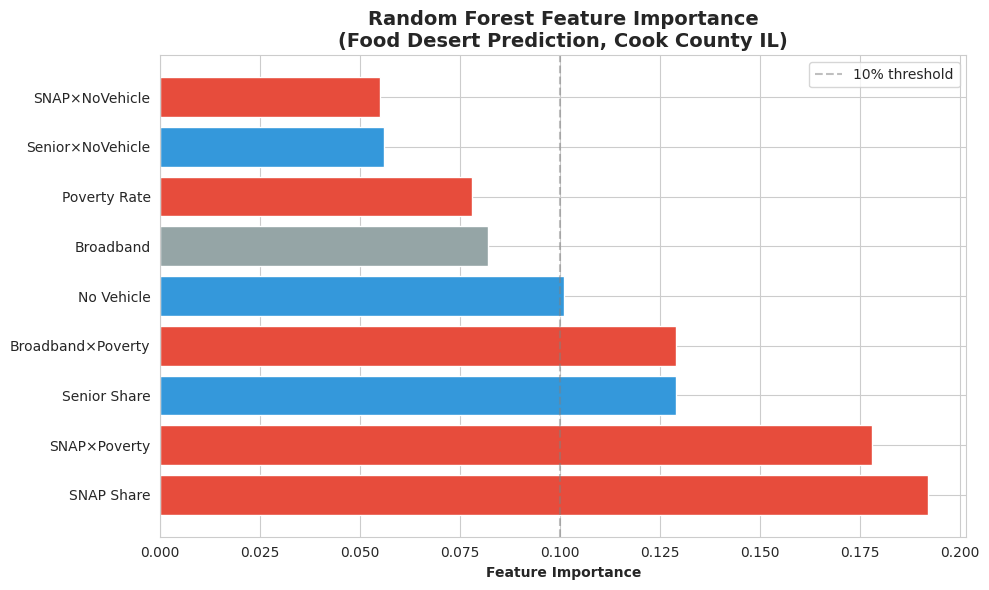

In [ ]:
# Your results
features = ['SNAP Share', 'SNAP×Poverty', 'Senior Share', 'Broadband×Poverty',
            'No Vehicle', 'Broadband', 'Poverty Rate', 'Senior×NoVehicle', 'SNAP×NoVehicle']
importance = [0.192, 0.178, 0.129, 0.129, 0.101, 0.082, 0.078, 0.056, 0.055]

plt.figure(figsize=(10, 6))
plt.barh(features, importance, color=['#e74c3c' if 'SNAP' in f or 'Poverty' in f else
                                       '#3498db' if 'Senior' in f or 'Vehicle' in f else
                                       '#95a5a6' for f in features])
plt.xlabel('Feature Importance', fontweight='bold')
plt.title('Random Forest Feature Importance\n(Food Desert Prediction, Cook County IL)',
          fontweight='bold', fontsize=14)
plt.axvline(x=0.10, color='gray', linestyle='--', alpha=0.5, label='10% threshold')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate best model with CV
cv_scores = cross_val_score(
    logreg_balanced,
    X_expanded,
    y_expanded,
    cv=cv,
    scoring='roc_auc'
)

print(f"\nCross-Validation ROC-AUC Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.3f}")

print(f"\nMean CV ROC-AUC: {cv_scores.mean():.3f}")
print(f"Std Dev: {cv_scores.std():.3f}")
print(f"95% CI: [{cv_scores.mean() - 1.96*cv_scores.std():.3f}, "
      f"{cv_scores.mean() + 1.96*cv_scores.std():.3f}]")

# Test if model is better than random
from scipy.stats import ttest_1samp
t_stat, p_val = ttest_1samp(cv_scores, 0.5)
print(f"\nt-test vs random (0.5): p = {p_val:.4f}")
if p_val < 0.05:
    print("Model significantly better than random guessing")


Cross-Validation ROC-AUC Scores:
  Fold 1: 0.839
  Fold 2: 0.796
  Fold 3: 0.878
  Fold 4: 0.841
  Fold 5: 0.837

Mean CV ROC-AUC: 0.838
Std Dev: 0.026
95% CI: [0.787, 0.889]

t-test vs random (0.5): p = 0.0000
Model significantly better than random guessing



Optimal Threshold: 0.50
F1-Score at optimal: 0.125
Precision: 0.070
Recall: 0.600


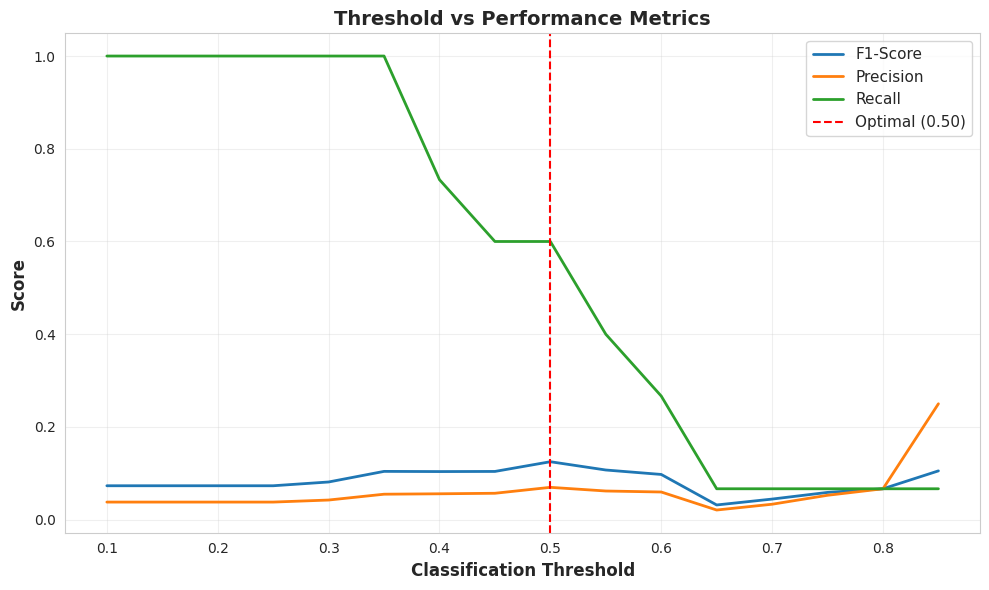

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Test different thresholds
thresholds_to_test = np.arange(0.1, 0.9, 0.05)
f1_scores = []
precisions = []
recalls = []

for thresh in thresholds_to_test:
    y_pred_thresh = (y_pred_proba_balanced >= thresh).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh))

# Find optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds_to_test[optimal_idx]

print(f"\nOptimal Threshold: {optimal_threshold:.2f}")
print(f"F1-Score at optimal: {f1_scores[optimal_idx]:.3f}")
print(f"Precision: {precisions[optimal_idx]:.3f}")
print(f"Recall: {recalls[optimal_idx]:.3f}")

# Visualize
plt.figure(figsize=(10, 6))
plt.plot(thresholds_to_test, f1_scores, label='F1-Score', linewidth=2)
plt.plot(thresholds_to_test, precisions, label='Precision', linewidth=2)
plt.plot(thresholds_to_test, recalls, label='Recall', linewidth=2)
plt.axvline(x=optimal_threshold, color='red', linestyle='--',
            label=f'Optimal ({optimal_threshold:.2f})')
plt.xlabel('Classification Threshold', fontweight='bold', fontsize=12)
plt.ylabel('Score', fontweight='bold', fontsize=12)
plt.title('Threshold vs Performance Metrics', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

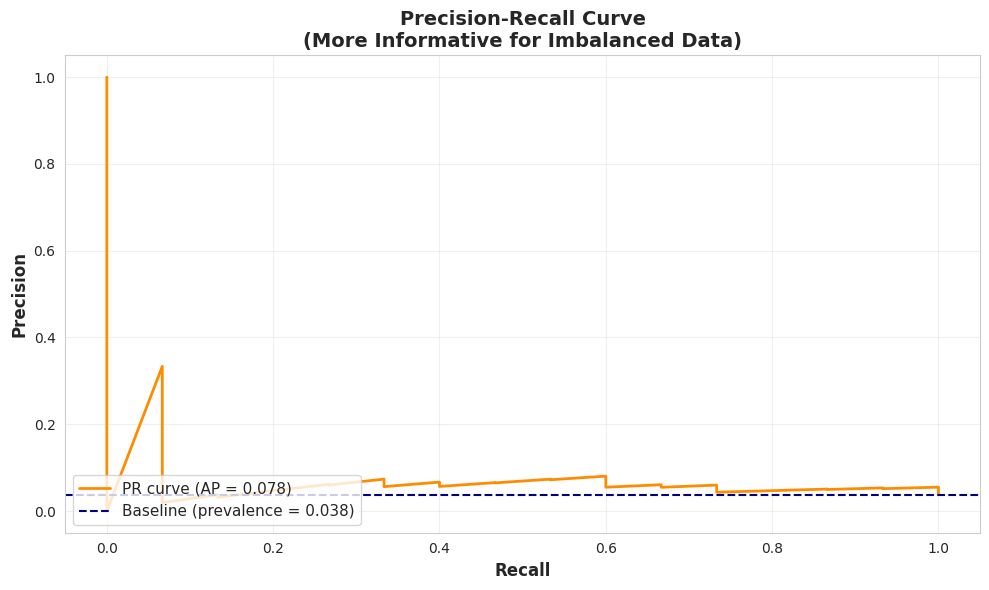


Average Precision Score: 0.078
(Random classifier would get: 0.038)


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_balanced)
ap_score = average_precision_score(y_test, y_pred_proba_balanced)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='darkorange', lw=2,
         label=f'PR curve (AP = {ap_score:.3f})')
plt.axhline(y=y_test.mean(), color='navy', linestyle='--',
            label=f'Baseline (prevalence = {y_test.mean():.3f})')
plt.xlabel('Recall', fontweight='bold', fontsize=12)
plt.ylabel('Precision', fontweight='bold', fontsize=12)
plt.title('Precision-Recall Curve\n(More Informative for Imbalanced Data)',
          fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAverage Precision Score: {ap_score:.3f}")
print(f"(Random classifier would get: {y_test.mean():.3f})")

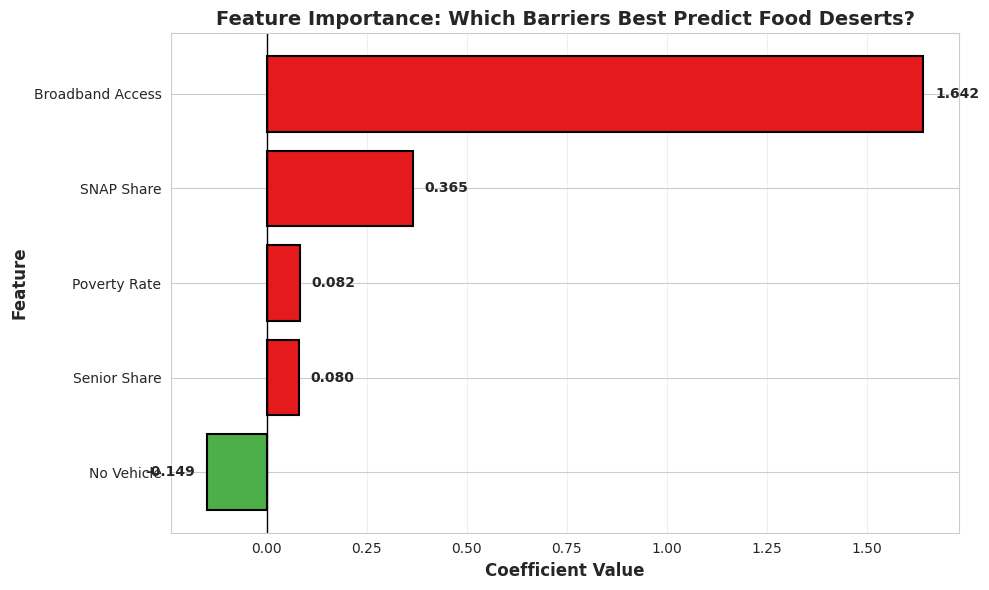


Logistic Regression Coefficients (Individual Components):
  Broadband Access         : +1.6419  ↑ Increases food desert likelihood
  Senior Share             : +0.0804  ↑ Increases food desert likelihood
  SNAP Share               : +0.3654  ↑ Increases food desert likelihood
  No Vehicle               : -0.1489  ↓ Decreases food desert likelihood
  Poverty Rate             : +0.0823  ↑ Increases food desert likelihood

🎯 Ranked by Predictive Strength (Absolute Value):
  1. Broadband Access         : |+1.6419| = 1.6419
  3. SNAP Share               : |+0.3654| = 0.3654
  4. No Vehicle               : |-0.1489| = 0.1489
  5. Poverty Rate             : |+0.0823| = 0.0823
  2. Senior Share             : |+0.0804| = 0.0804

Interpretation:
  ✓ Positive coefficient = Higher value → More likely food desert
  ✓ Negative coefficient = Higher value → Less likely food desert
  ✓ Largest absolute value = Strongest predictor

📊 Model Performance (Expanded Features):
  ROC-AUC Score: 0.820
  Compa

In [ ]:
# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
colors = ['#e41a1c' if c > 0 else '#4daf4a' for c in coef_df['Coefficient']]
bars = plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors,
                edgecolor='black', linewidth=1.5)

plt.xlabel('Coefficient Value', fontweight='bold', fontsize=12)
plt.ylabel('Feature', fontweight='bold', fontsize=12)
plt.title('Feature Importance: Which Barriers Best Predict Food Deserts?',
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (feat, coef) in enumerate(zip(coef_df['Feature'], coef_df['Coefficient'])):
    offset = 0.03 if coef > 0 else -0.03
    plt.text(coef + offset, i, f'{coef:.3f}',
             va='center', ha='left' if coef > 0 else 'right',
             fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Print detailed results
print(f"\nLogistic Regression Coefficients (Individual Components):")
print("="*70)
for feat, coef in zip(feature_names_expanded, coefficients_expanded):
    direction = "↑ Increases" if coef > 0 else "↓ Decreases"
    print(f"  {feat:25s}: {coef:+.4f}  {direction} food desert likelihood")

# Rank by absolute importance
coef_abs = pd.DataFrame({
    'Feature': feature_names_expanded,
    'Coefficient': coefficients_expanded,
    'Abs_Coefficient': np.abs(coefficients_expanded)
}).sort_values('Abs_Coefficient', ascending=False)

print(f"\n🎯 Ranked by Predictive Strength (Absolute Value):")
print("="*70)
for idx, row in coef_abs.iterrows():
    print(f"  {idx+1}. {row['Feature']:25s}: |{row['Coefficient']:+.4f}| = {row['Abs_Coefficient']:.4f}")

print(f"\nInterpretation:")
print(f"  ✓ Positive coefficient = Higher value → More likely food desert")
print(f"  ✓ Negative coefficient = Higher value → Less likely food desert")
print(f"  ✓ Largest absolute value = Strongest predictor")

# Model performance with expanded features
y_pred_exp = log_reg_expanded.predict(X_test_exp)
y_pred_proba_exp = log_reg_expanded.predict_proba(X_test_exp)[:, 1]
roc_auc_exp = roc_auc_score(y_test_exp, y_pred_proba_exp)

print(f"\n📊 Model Performance (Expanded Features):")
print(f"  ROC-AUC Score: {roc_auc_exp:.3f}")
print(f"  Comparison to basic model: {roc_auc_exp - roc_auc:+.3f}")


ML VISUALIZATION 3: Confusion Matrix


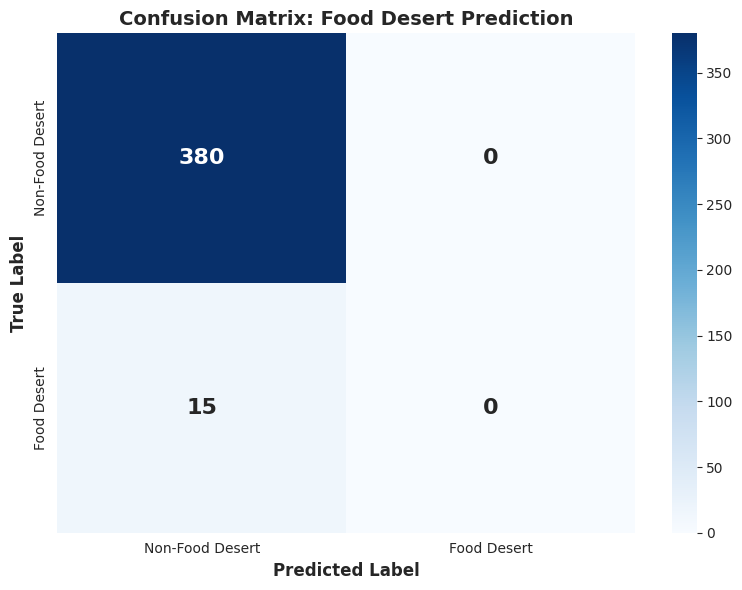


Confusion Matrix Breakdown:
  True Negatives (TN):  380 - Correctly predicted non-food deserts
  False Positives (FP): 0 - Incorrectly predicted as food deserts
  False Negatives (FN): 15 - Missed food deserts
  True Positives (TP):  0 - Correctly predicted food deserts

Performance Metrics:
  Accuracy:  0.962 (96.2%)
  Precision: 0.000 (of predicted food deserts, 0.0% are correct)
  Recall:    0.000 (model finds 0.0% of actual food deserts)
  F1-Score:  0.000


In [ ]:
print("\n" + "="*70)
print("ML VISUALIZATION 3: Confusion Matrix")
print("="*70)

from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Non-Food Desert', 'Food Desert'],
            yticklabels=['Non-Food Desert', 'Food Desert'],
            annot_kws={'size': 16, 'weight': 'bold'})

plt.xlabel('Predicted Label', fontweight='bold', fontsize=12)
plt.ylabel('True Label', fontweight='bold', fontsize=12)
plt.title('Confusion Matrix: Food Desert Prediction',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN):  {tn} - Correctly predicted non-food deserts")
print(f"  False Positives (FP): {fp} - Incorrectly predicted as food deserts")
print(f"  False Negatives (FN): {fn} - Missed food deserts")
print(f"  True Positives (TP):  {tp} - Correctly predicted food deserts")

print(f"\nPerformance Metrics:")
print(f"  Accuracy:  {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"  Precision: {precision:.3f} (of predicted food deserts, {precision*100:.1f}% are correct)")
print(f"  Recall:    {recall:.3f} (model finds {recall*100:.1f}% of actual food deserts)")
print(f"  F1-Score:  {f1:.3f}")

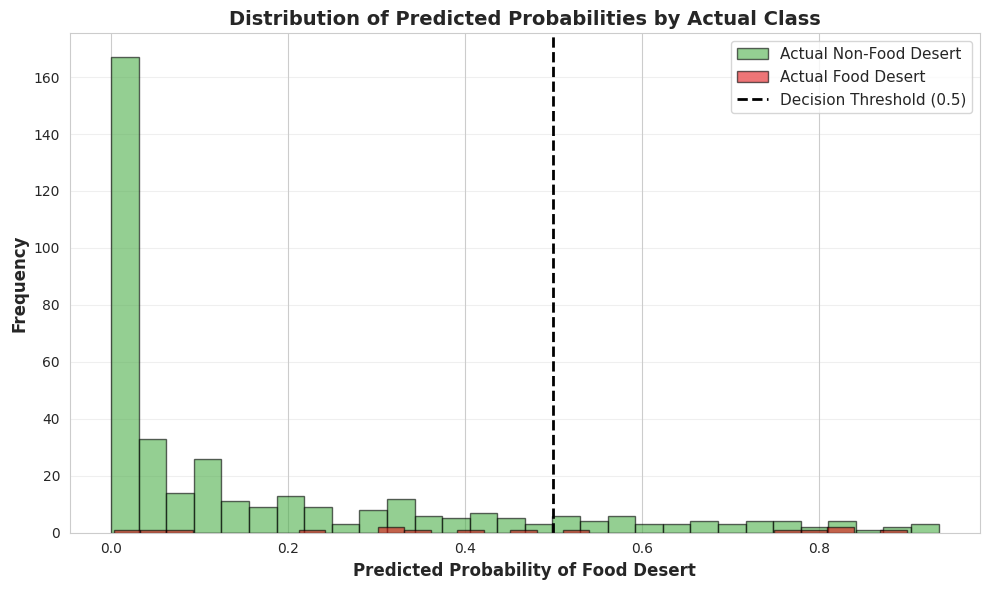


Probability Distribution Analysis:
  Actual Non-Food Deserts:
    Mean predicted probability: 0.172
    Median predicted probability: 0.052

  Actual Food Deserts:
    Mean predicted probability: 0.460
    Median predicted probability: 0.416

Interpretation:
  ✓ Good separation: Food deserts have higher predicted probabilities
  ✓ Model can distinguish between the two groups


In [ ]:
# Separate probabilities by actual class
prob_fd = y_pred_proba[y_test == 1]  # Probabilities for actual food deserts
prob_nfd = y_pred_proba[y_test == 0]  # Probabilities for actual non-food deserts

# Plot overlapping histograms
plt.figure(figsize=(10, 6))
plt.hist(prob_nfd, bins=30, alpha=0.6, label='Actual Non-Food Desert',
         color='#4daf4a', edgecolor='black')
plt.hist(prob_fd, bins=30, alpha=0.6, label='Actual Food Desert',
         color='#e41a1c', edgecolor='black')

plt.axvline(x=0.5, color='black', linestyle='--', linewidth=2,
            label='Decision Threshold (0.5)')

plt.xlabel('Predicted Probability of Food Desert', fontweight='bold', fontsize=12)
plt.ylabel('Frequency', fontweight='bold', fontsize=12)
plt.title('Distribution of Predicted Probabilities by Actual Class',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nProbability Distribution Analysis:")
print(f"  Actual Non-Food Deserts:")
print(f"    Mean predicted probability: {prob_nfd.mean():.3f}")
print(f"    Median predicted probability: {np.median(prob_nfd):.3f}")
print(f"\n  Actual Food Deserts:")
print(f"    Mean predicted probability: {prob_fd.mean():.3f}")
print(f"    Median predicted probability: {np.median(prob_fd):.3f}")

print(f"\nInterpretation:")
if prob_fd.mean() > prob_nfd.mean():
    print(f"  ✓ Good separation: Food deserts have higher predicted probabilities")
    print(f"  ✓ Model can distinguish between the two groups")
else:
    print(f"  ⚠ Poor separation: Distributions overlap significantly")